In [1]:
# MA Cross Backtesting on 1H EURUSD with following trade costs and timeframes
# - Slippage is 0.1BPS
# - Spread is 15pips
# - Initial capital is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/EURUSD.csv", parse_dates=True, index_col="datetime")
df_

,Open,High,Low,Close,Volume,Spread
datetime,,,,,,
2009-10-20 04:14:00+00:00,1.49814,1.49816,1.49812,1.49812,12,17
2009-10-20 04:15:00+00:00,1.49810,1.49822,1.49806,1.49820,24,16
2009-10-20 04:16:00+00:00,1.49819,1.49820,1.49805,1.49807,22,16
2009-10-20 04:17:00+00:00,1.49805,1.49805,1.49801,1.49803,6,16
2009-10-20 04:18:00+00:00,1.49801,1.49801,1.49789,1.49799,28,16
...,...,...,...,...,...,...
2023-10-16 03:35:00+00:00,1.05200,1.05206,1.05197,1.05206,21,9
2023-10-16 03:36:00+00:00,1.05206,1.05217,1.05206,1.05217,12,9
2023-10-16 03:37:00+00:00,1.05217,1.05217,1.05214,1.05217,6,9


<Axes: xlabel='datetime'>

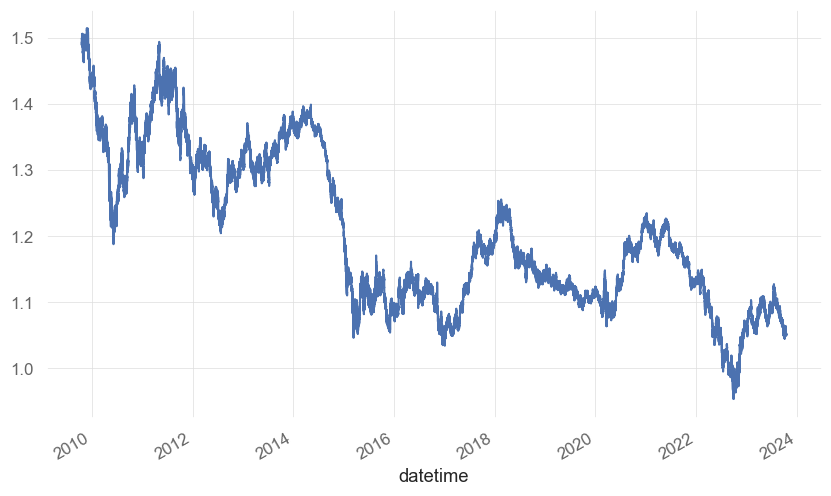

In [4]:
df_['Close'].plot()

In [5]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2009-10-20 04:00:00+00:00,1.49814,1.49822,1.49644,1.49725,1002
2009-10-20 05:00:00+00:00,1.49724,1.49846,1.49653,1.49805,1534
2009-10-20 06:00:00+00:00,1.49804,1.49808,1.49657,1.49781,1879
2009-10-20 07:00:00+00:00,1.49785,1.49870,1.49655,1.49857,3018
2009-10-20 08:00:00+00:00,1.49855,1.49866,1.49560,1.49613,3128
...,...,...,...,...,...
2023-10-15 23:00:00+00:00,1.05213,1.05222,1.05168,1.05216,745
2023-10-16 00:00:00+00:00,1.05218,1.05234,1.05153,1.05173,1564
2023-10-16 01:00:00+00:00,1.05173,1.05251,1.05173,1.05216,1319


In [6]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [7]:
df['Signal'].value_counts()

Signal
 0    85438
-1      976
 1      975
Name: count, dtype: int64

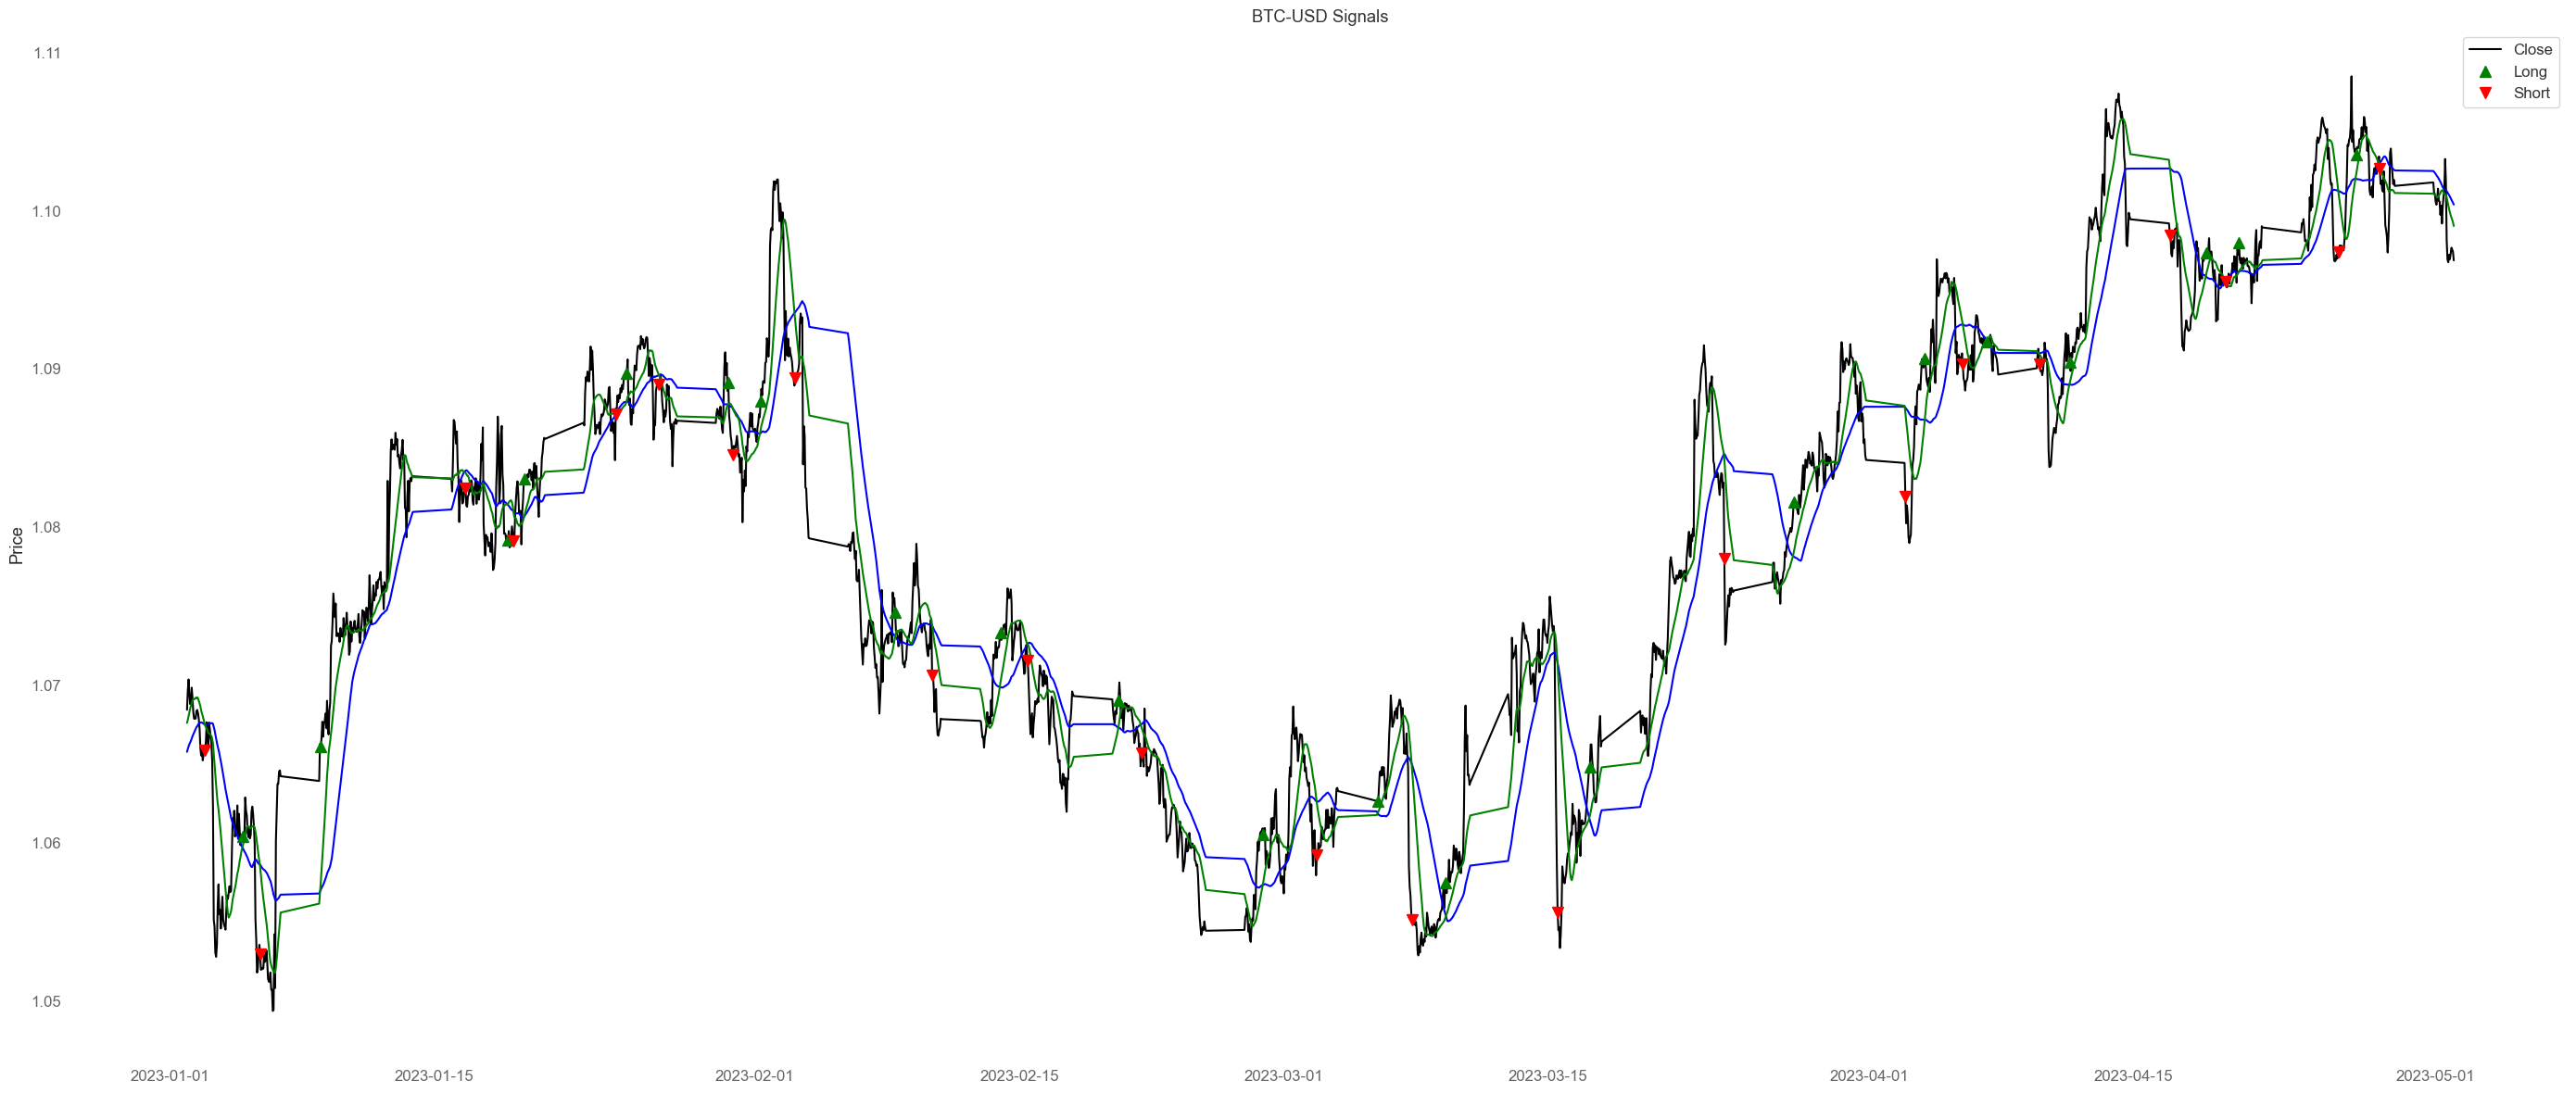

In [11]:
plot_df = df["2023-01-01":"2023-05-01"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [12]:
# Position tracking with slippage

slippage_bps        = 0.1 / 10000    # 0.1 bps
spread_by_pips      = 15             # 15  pips for spread
spread_to_pip_ratio = 1.0            # in JPY based pairs, this ratio would be different
spread_by_bps       = (spread_by_pips / 10000) * spread_to_pip_ratio
trading_cost_bps    = slippage_bps + spread_by_bps

position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close'] * (1 - trading_cost_bps) if position == 1 else row['Close'] * (1 + trading_cost_bps)
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 + trading_cost_bps)
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 - trading_cost_bps)
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [13]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.0     # 0.0 because broker will charge through the spread instead of commission
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [14]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2009-10-26 14:00:00+00:00,2009-10-26 15:00:00+00:00,1.498344,1.496226,-0.141368,-0.141368,-28.273669,9971.726331,NaN
2009-10-29 21:00:00+00:00,2009-10-29 22:00:00+00:00,1.485800,1.481719,-0.274664,-0.416032,-54.777445,9916.948887,-0.005493
2009-11-01 23:00:00+00:00,2009-11-02 00:00:00+00:00,1.468110,1.475324,0.491420,0.075387,97.467661,10014.416548,0.009828
2009-11-03 03:00:00+00:00,2009-11-03 04:00:00+00:00,1.480122,1.476098,-0.271862,-0.196475,-54.450840,9959.965708,-0.005437
2009-11-03 12:00:00+00:00,2009-11-03 13:00:00+00:00,1.463187,1.467322,0.282607,0.086132,56.295128,10016.260835,0.005652
...,...,...,...,...,...,...,...,...
2023-10-02 10:00:00+00:00,2023-10-02 11:00:00+00:00,1.052339,1.054690,0.223466,-3.069340,40.201371,9035.178851,0.004469
2023-10-04 14:00:00+00:00,2023-10-04 15:00:00+00:00,1.050844,1.050142,-0.066851,-3.136190,-12.080128,9023.098723,-0.001337
2023-10-09 16:00:00+00:00,2023-10-09 17:00:00+00:00,1.051919,1.057905,0.569039,-2.567151,102.689862,9125.788586,0.011381


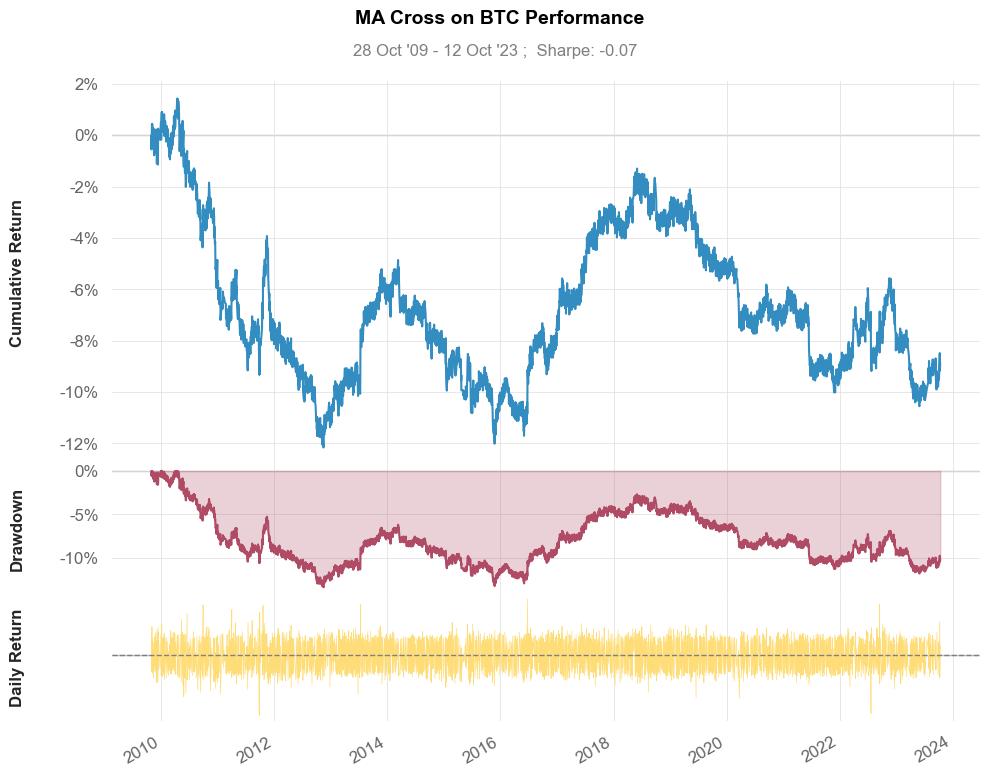

In [15]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC Performance', show=True);

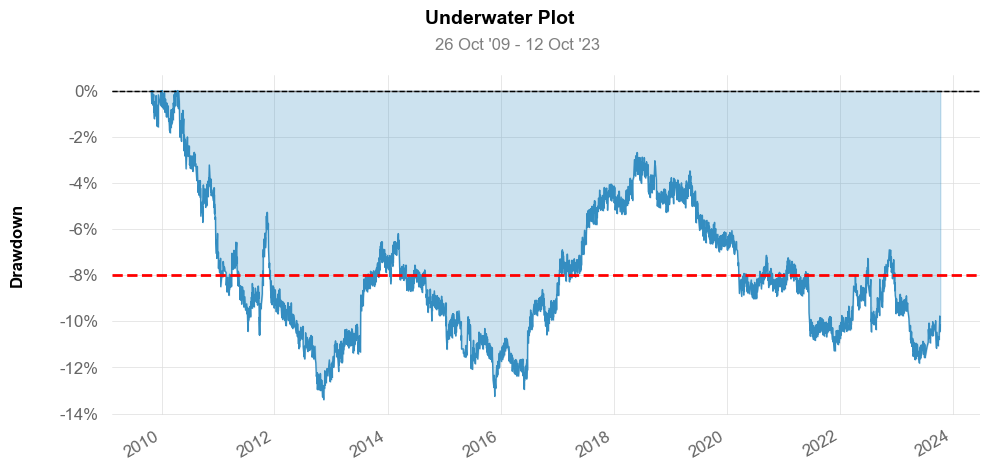

In [16]:
qs.plots.drawdown(position_df['Account Change'])

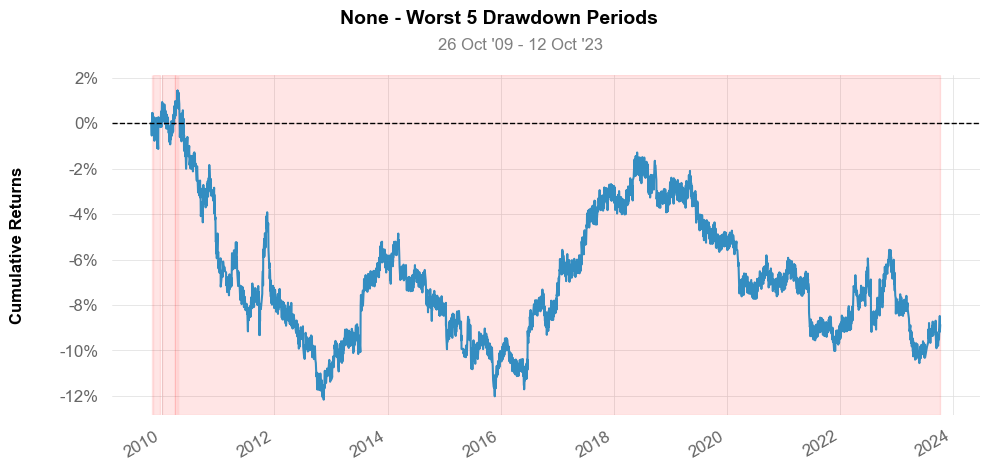

In [17]:
qs.plots.drawdowns_periods(position_df['Account Change'])

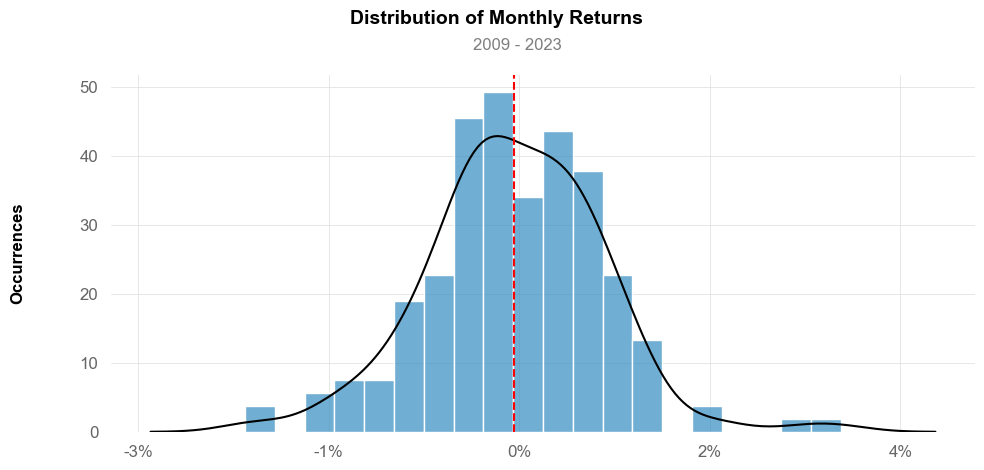

In [18]:
qs.plots.histogram(position_df['Account Change'])

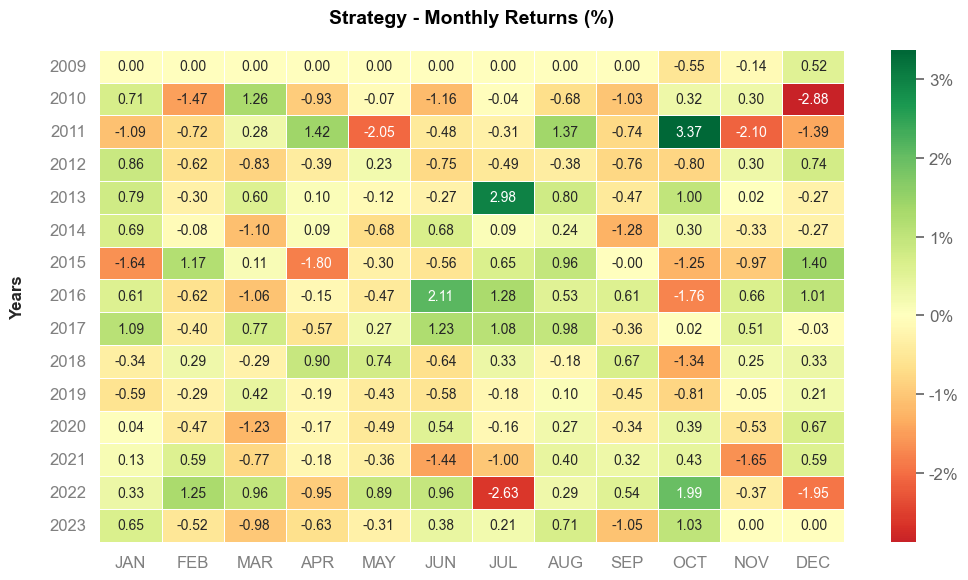

In [19]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [20]:
qs.stats.sharpe(position_df['Account Change'])

-0.06679205099453579

<Axes: xlabel='Entry Time'>

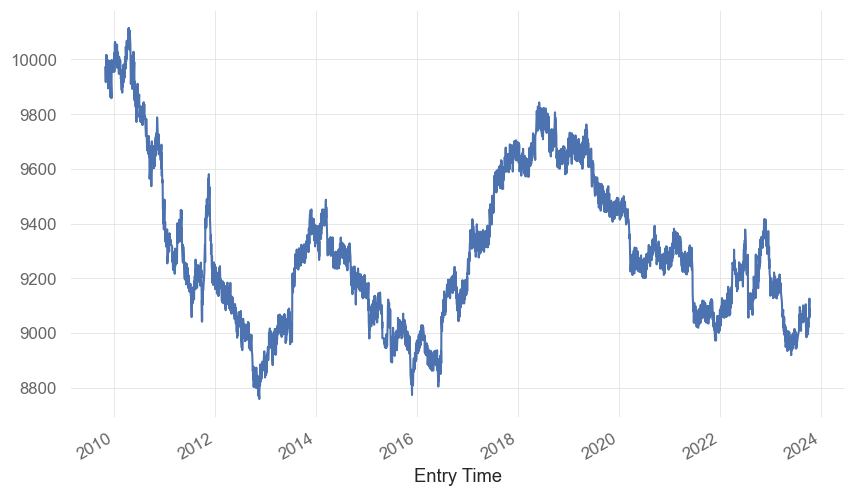

In [21]:
position_df["Account History"].plot()